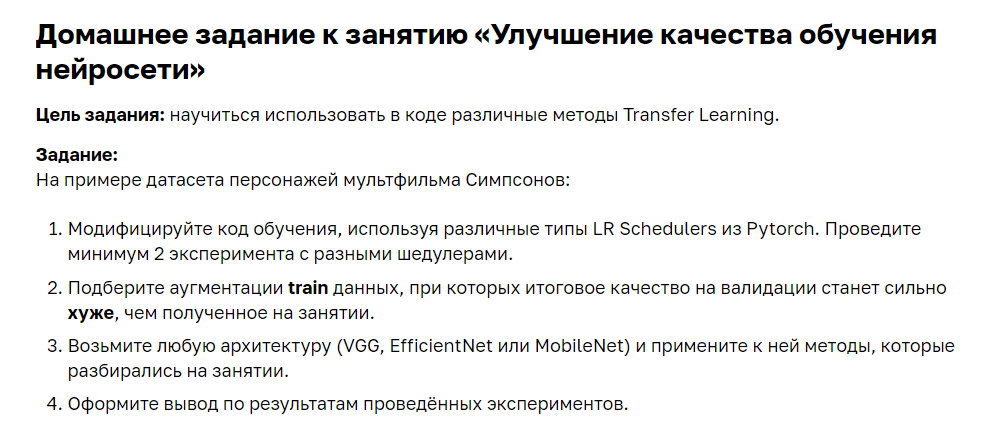

In [50]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

from collections import defaultdict
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)

In [25]:
!pip install kaggle
!pip install split-folders

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

Dataset URL: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset

License(s): CC-BY-NC-SA-4.0


100% 1.08G/1.08G [00:12<00:00, 115MB/s] 

100% 1.08G/1.08G [00:12<00:00, 89.2MB/s]


In [5]:
!unzip the-simpsons-characters-dataset.zip -d simpsons_dataset

Streaming output truncated to the last 5000 lines.

  inflating: simpsons_dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1271.jpg  

  inflating: simpsons_dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1272.jpg  

  inflating: simpsons_dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1273.jpg  

  inflating: simpsons_dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1274.jpg  

  inflating: simpsons_dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1275.jpg  

  inflating: simpsons_dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1276.jpg  

  inflating: simpsons_dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1277.jpg  

  inflating: simpsons_dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1278.jpg  

  inflating: simpsons_dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1279.jpg  

  inflating: simpsons_dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1280.jpg  

  inflating: simpsons_datase

In [6]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "/content/simpsons_dataset/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653

Изображений в val: 6280


In [8]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    target_transform=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    target_transform=lambda x: x in val_files_path
)

In [9]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  43

Количество классов в val:  43

Количество классов одинаково:  True


In [10]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

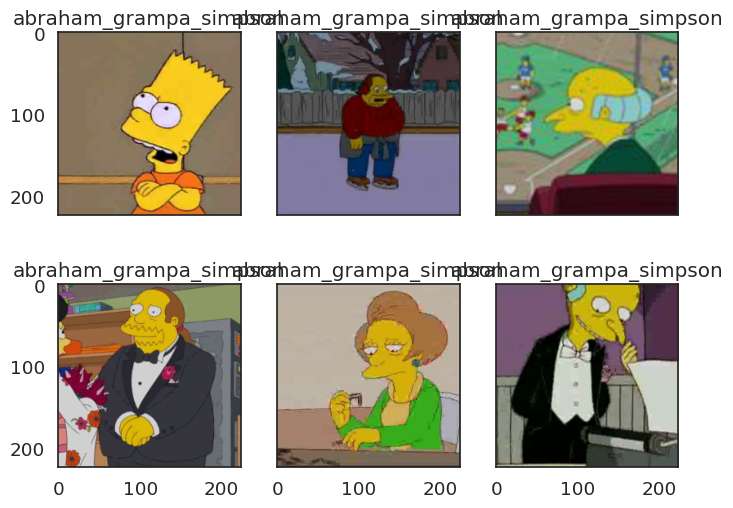

In [11]:
show_images(val_dataset)

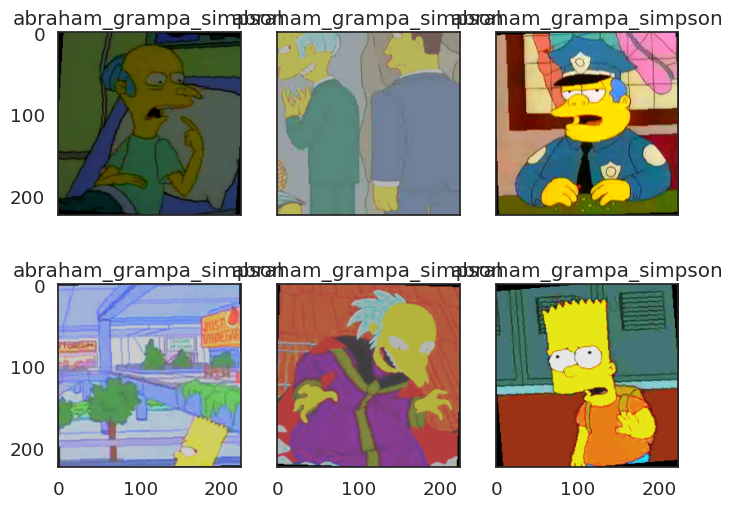

In [12]:
show_images(train_dataset)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [15]:
def train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        scheduler.step()

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [16]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [14]:
from torchvision.models import resnet18

In [15]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 43)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [16]:
# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [46]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

In [21]:
# Эксперимент 1: Используем StepLR
scheduler_steplr = StepLR(optimizer, step_size=5, gamma=0.1)

Epoch 2 of 2 took 614.161s

  training loss (in-iteration): 	0.000000

  validation loss (in-iteration): 	0.000000

  training accuracy: 			100.00 %

  validation accuracy: 			100.00 %


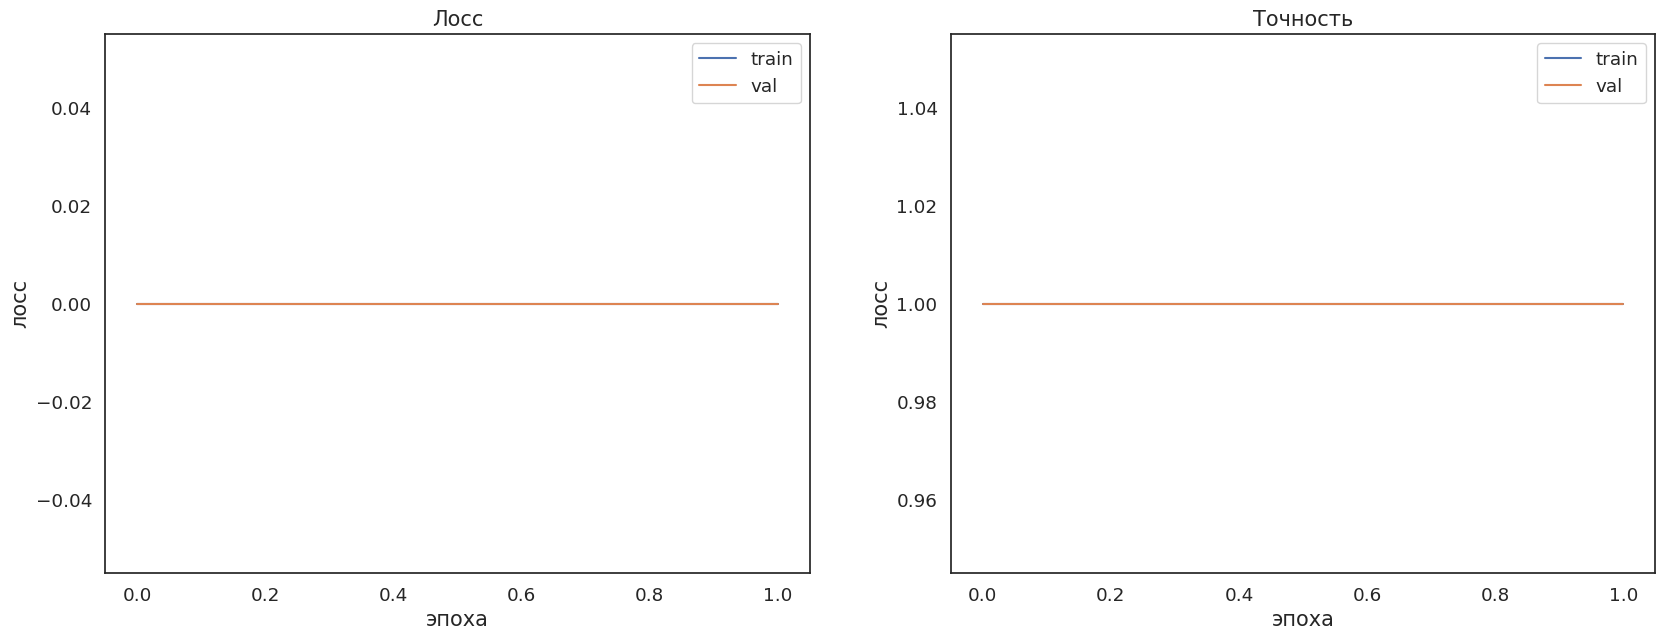

In [24]:
clf_model, history = train(
    model, criterion, optimizer, scheduler_steplr,
    train_batch_gen, val_batch_gen,
    num_epochs=2
)

In [36]:
# Эксперимент 2: Используем ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Пересоздаем оптимизатор для второго эксперимента
scheduler_reduce_on_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [37]:
def train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

        # Обновляем планировщик LR на основе метрики (например, validation loss)
        scheduler.step(val_loss)

    return model, history

Epoch 2 of 2 took 624.275s

  training loss (in-iteration): 	0.000000

  validation loss (in-iteration): 	0.000000

  training accuracy: 			100.00 %

  validation accuracy: 			100.00 %


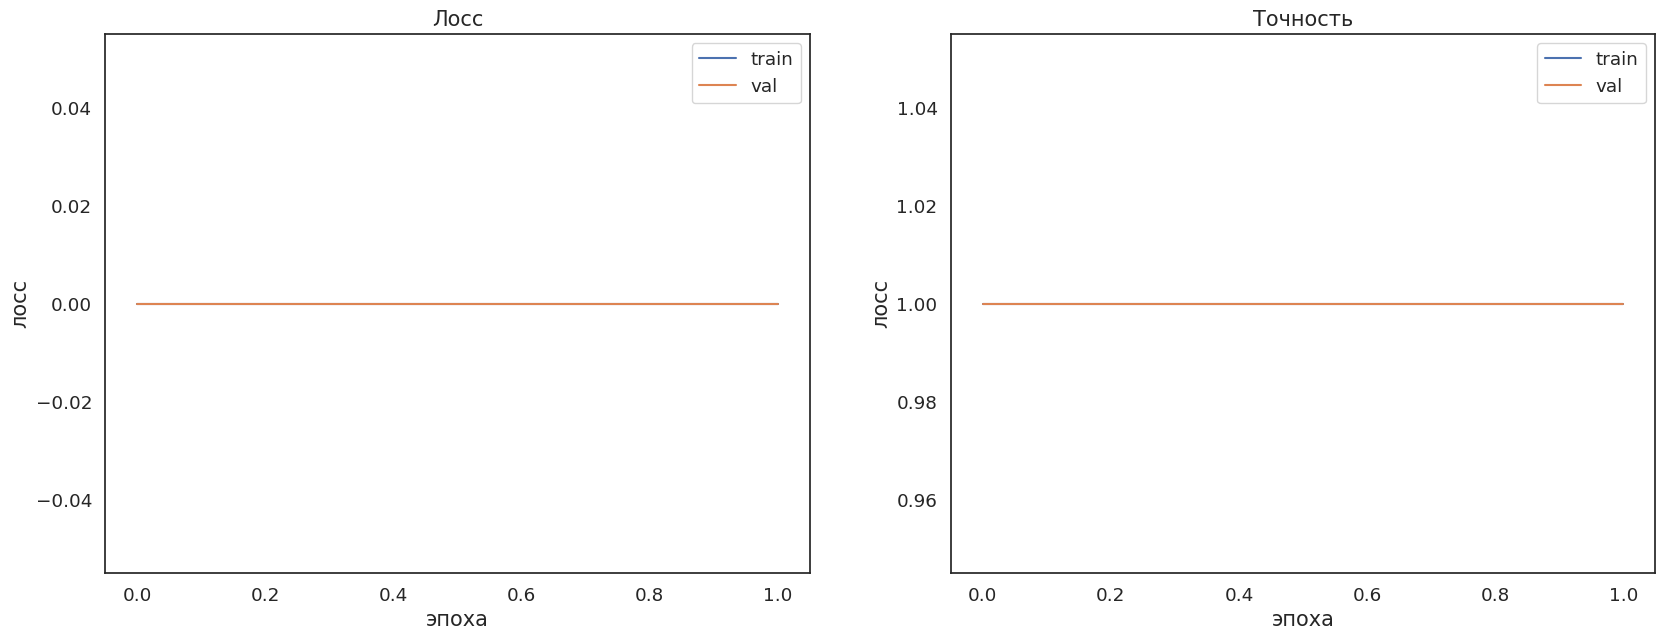

In [29]:
clf_model, history = train(
    model, criterion, optimizer, scheduler_reduce_on_plateau,
    train_batch_gen, val_batch_gen,
    num_epochs=2
)

Модели получились слишком хорошие, вычилительные мощности не бесконечные, пробовал в другом ноутбуке обучать модель снуля, получилось тоже самое, поэтому испортим картинки и попробуем снова. 

In [32]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(brightness=0.5, contrast=0.7, saturation=0.5, hue=0.5),
    transforms.RandomRotation(150),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomResizedCrop(input_size, scale=(0.7, 1.0)),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    target_transform=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    target_transform=lambda x: x in val_files_path
)

In [34]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Epoch 2 of 2 took 784.096s
  training loss (in-iteration): 	0.000000
  validation loss (in-iteration): 	0.000000
  training accuracy: 			100.00 %
  validation accuracy: 			100.00 %


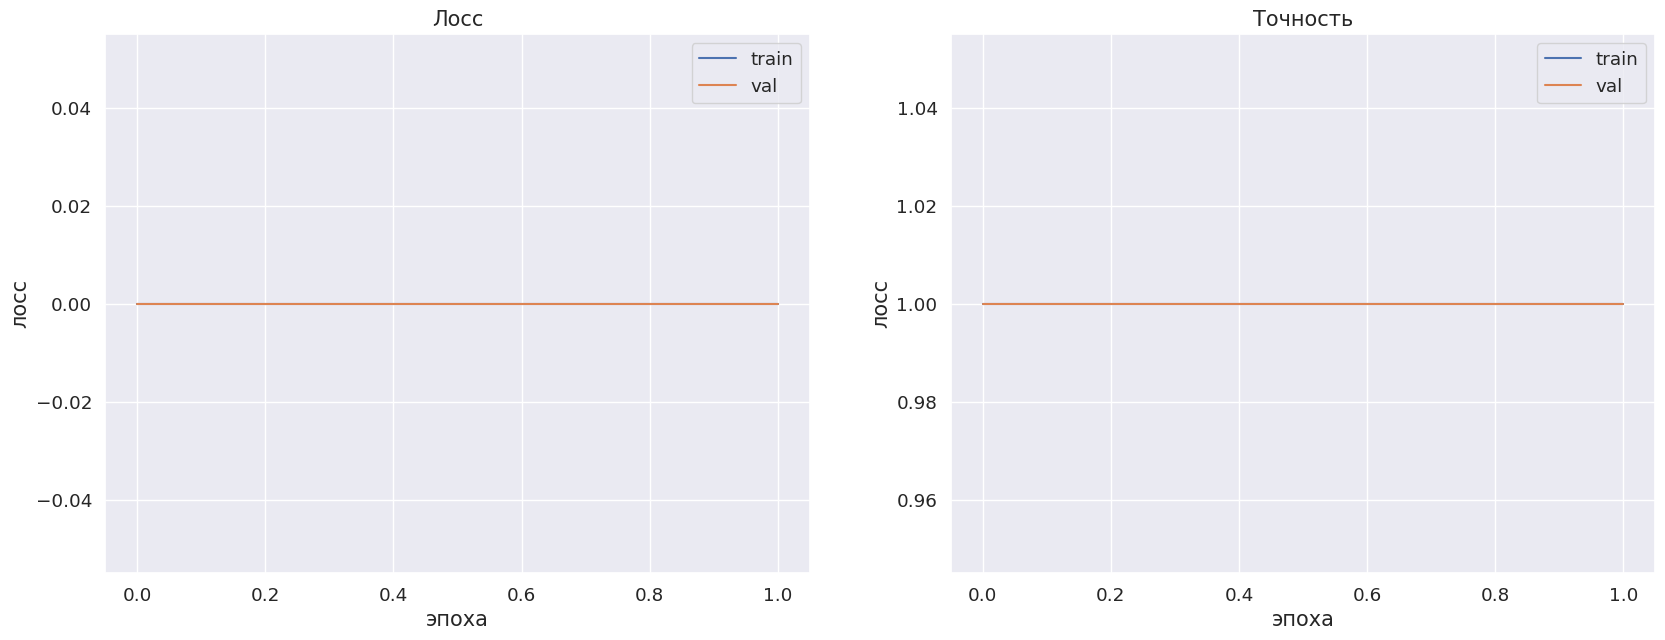

In [38]:
clf_model, history = train(
    model, criterion, optimizer, scheduler_reduce_on_plateau,
    train_batch_gen, val_batch_gen,
    num_epochs=2
)

In [ ]:
#мои манипуляции с ухудшением данных не дали результатов, поэтоу ухудшим еще данные и используем другую модель

In [41]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    target_transform=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    target_transform=lambda x: x in val_files_path
)

In [43]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [47]:
model = models.mobilenet_v2(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, len(train_dataset.classes))
)
model = model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 102MB/s] 


In [49]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
# Можно также попробовать другие планировщики LR:
# scheduler = ReduceLROnPlateau(optimizer, 'min')
scheduler = CosineAnnealingLR(optimizer, T_max=10)

In [51]:
def plot_learning_curves(history):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

def train(
    model, 
    criterion,
    optimizer,
    scheduler, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        model.train(True)

        for X_batch, y_batch in train_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        scheduler.step()

        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        model.train(False)

        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

Epoch 3 of 3 took 665.682s
  training loss (in-iteration): 	0.000001
  validation loss (in-iteration): 	0.000001
  training accuracy: 			100.00 %
  validation accuracy: 			100.00 %


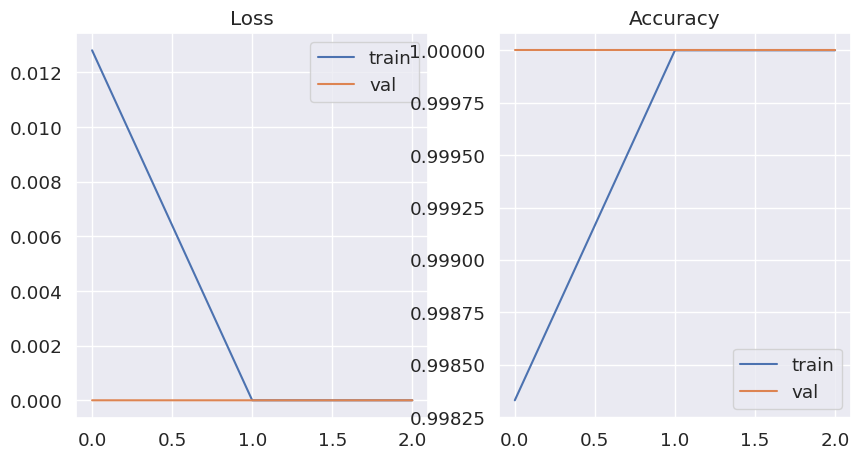

In [53]:
model, history = train(
    model, criterion, optimizer, scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=3
)

Можно сделать вывод, что современные модели далеко ушли в своем развитии, совершают отличную классификацию на различных данных, изменения цвета, размера, наклона и других параметров не смогли ухудшить качества моделей, при этом в другом ноутбке пробовал моедли без предобучения, качество было такое же, единственная проблема это вычислительные мощности и невозможность расширения до платных версий из-за отсутствия международных платежей. 